# Setup

### Imports

In [1]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
import time
from os import path
from pathlib import Path
from datetime import datetime
from copy import deepcopy

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA

# metrics
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# training
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

### Initial tasks

In [2]:
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import sys, os, warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# also suppress warnings of parallel processes such as grid search cv
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
# configure pandas
pd.set_option("display.max_columns", None)

### Utils / Helpers

In [3]:
def merge(a, b):
    return {**a, **b}

def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')
    
def print_dim(text):
    print(colored(text, 'grey'))

In [4]:
class Time(object):
    def __enter__(self):
        self.start_time = time.time()
  
    def __exit__(self, *args, **kwargs):
        print("--- took %.2f seconds ---" % (time.time() - self.start_time))

In [5]:
class Output:
    class printer(str):
        def __repr__(self):
            return self
    
    def __init__(self):
        self.out = None
    
    def update(self, output):
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)

In [6]:
class PrintDuration(object):
    class printer(str):
        def __repr__(self):
            return self
        
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        
        self.completed = False
        self.progress = 0
        self.ert = 0
        self.att = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.completed = True
        self.render()
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def render(self):
        output = ''
        
        if self.completed:
            complete_time = (datetime.now() - self.start_time).total_seconds()
            complete_time = self.tdformat(complete_time)
            output = f'100% completed, total run time = {complete_time}'
        else:
            percent = round(self.progress * 100)
            att = self.tdformat(self.att)
            ert = self.tdformat(self.ert)
            output = f'{percent}% completed, remaining time = {ert}, avg ticktime = {att}'
        
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time
        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # set
        self.progress = progress
        self.att = avg_tick_time
        self.ert = est_remain_time
        
        # render
        self.render() 

### Detect Env

In [7]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [8]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_models = path.join(path_root, 'models')

if ENV_KAGGLE:
    path_root = '/kaggle/working'
    path_dataset = '/kaggle/input/personal-key-indicators-of-heart-disease'
    path_csv = path_dataset
    path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

### Constants

In [9]:
TARGET_COLUMN = 'HeartDisease'

### Configs

In [10]:
cfg_autosave_models = False
cfg_force_train = False
cfg_csv_name = 'data.csv'

if ENV_KAGGLE:
    cfg_autosave_models = True
    cfg_force_train = False
    cfg_csv_name = 'heart_2020_cleaned.csv'

# Hyperparameters

In [11]:
hp_scoring = ('raw', 'f1')
hp_seed = 0
hp_cv_splits = (2, 2)
hp_test_size = 0.2

# Preprocessing

In [12]:
# read csv
data = pd.read_csv(path.join(path_csv, cfg_csv_name), encoding='utf-8')

## Limit Data

In [13]:
# limit data helper
def use_limited_data(data, limit):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=limit, random_state=hp_seed)
    _, test_index = next(iter(splitter.split(data, data[TARGET_COLUMN])))
    return data.loc[test_index].reset_index(drop=True)

# always keep full data
full_data = data

# use limited data (for local tests)
# data = use_limited_data(full_data, 3200)

### Simple EDA

In [14]:
data.shape
data.info()

(319795, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [15]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00


In [17]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [18]:
data.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

# Pipeline Setup

In [19]:
class OutlierRemover:
    @staticmethod
    def numeric(data):
        cols = data.select_dtypes(include=['float64', 'int64']).columns.to_list()
        return OutlierRemover(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.bands = {}
    
    def fit(self, data):
        for col in self.cols:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_band = Q1 - 1.5 * IQR
            upper_band = Q3 + 1.5 * IQR
            
            self.bands[col] = (lower_band, upper_band)
    
    def transform(self, data):
        for col in self.cols:
            lower_band, upper_band = self.bands[col]
            inliers = ~((data[col] < lower_band) | (data[col] > upper_band))
            data = data[inliers]
            
        return data
            
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
class MultiLabelEncoder():
    @staticmethod
    def binary(data):
        cols = [col for col in data.columns if data[col].nunique() == 2]
        return MultiLabelEncoder(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {col: LabelEncoder() for col in cols}
    
    def fit(self, data):
        for col in self.cols:
            self.encoders[col].fit(data[col])

    def transform(self, data):
        for col in self.cols:
            data[col] = self.encoders[col].transform(data[col])
        
        return data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

class Preprocessor:
    @staticmethod
    def params(override={}):
        defaults = {
            'target': 'HeartDisease',
            'outlier_strategy': 'all',
            'encode_labels': True,
            'pca': False,
            'onehot_encoding': ['Race', 'Diabetic'],
            'ordinal_encoding': {
                'GenHealth': ['Poor', 'Fair', 'Good', 'Very good','Excellent'],
                'AgeCategory': ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54',
                                '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
            }
        }

        return merge(defaults, override)
    
    @staticmethod
    def process(*args, **kwargs):
        processor = Preprocessor(*args, **kwargs)
        processor.apply()
        return processor
    
    def __init__(self, data, test_index=None, train_index=None, options=None):
        if options is None:
            options = Preprocessor.params()
        
        if train_index is None:
            train_index = list(range(len(data)))
            test_index = []
        
        self.data = data
        self.test_index = np.array(test_index)
        self.train_index = np.array(train_index)
        self.options = options
        
        self.target = self.options['target']
        self.update_meta()
    
    def update_meta(self):
        self.features_mask = self.data.columns != self.target
        self.columns = self.data.columns
        self.feature_columns = self.columns[self.features_mask]
        self.has_train = self.train_index.shape[0] > 0
        self.has_test = self.test_index.shape[0] > 0

    def override_data(self, value):
        labels = self.y
        self.data = pd.DataFrame(data=value, index=self.data.index)
        self.data[self.target] = labels
        self.update_meta()
            
    def get_x(self, df):
        return df.drop(self.target, axis=1).to_numpy()
    
    def get_y(self, df):
        return df[self.target].to_numpy()
    
    # .x getter/setter
    @property
    def x(self):
        return self.get_x(self.data)
    
    @x.setter
    def x(self, value):
        self.data.loc[:, self.features_mask] = value
        
    # .y getter/setter
    @property
    def y(self):
        return self.get_y(self.data)
    
    @y.setter
    def y(self, value):
        self.data.loc[:, [self.target]] = value
    
    # .test getter/setter
    @property
    def test(self):
        return self.data.loc[self.test_index]
    
    @test.setter
    def test(self, value):
        self.data.loc[self.test_index] = value
    
    # .train getter/setter
    @property
    def train(self):
        return self.data.loc[self.train_index]
    
    @train.setter
    def train(self, value):
        self.data.loc[self.train_index] = value
    
    # .x_test getter/setter
    @property
    def x_test(self):
        return self.get_x(self.test)
    
    @x_test.setter
    def x_test(self, value):
        self.data.loc[self.test_index, self.features_mask] = value
        
    # .x_train getter/setter
    @property
    def x_train(self):
        return self.get_x(self.train)
    
    @x_train.setter
    def x_train(self, value):
        self.data.loc[self.train_index, self.features_mask] = value
    
    # .y_test getter
    @property
    def y_test(self):
        return self.get_y(self.test)
        
    # .y_test setter
    @property
    def y_train(self):
        return self.get_y(self.train)
    
    def chop(self):
        return self.x_test, self.y_test, self.x_train, self.y_train
    
    def apply(self):
        # remove outliers
        outlier_strategy = self.options.get('outlier_strategy', 'train_only')
        outlier_remover = OutlierRemover.numeric(self.data)
        if outlier_strategy == 'train_only':
            self.train = outlier_remover.fit_transform(self.train)
        elif outlier_strategy == 'include_test':
            outlier_remover.fit(self.train())
            self.data = outlier_remover.transform(self.data)
        elif outlier_strategy == 'all':
            self.data = outlier_remover.fit_transform(self.data)
        else:
            pass
        
        # update removed indexes.
        indexes = self.data.index.values
        self.train_index = self.train_index[np.isin(self.train_index, indexes)]
        self.test_index = self.test_index[np.isin(self.test_index, indexes)]
        
        # encode labels
        encode_labels = self.options.get('encode_labels', True)
        if encode_labels:
            self.data = MultiLabelEncoder.binary(self.data).fit_transform(self.data)
            
        onehot_encoding = self.options.get('onehot_encoding', None)
        if onehot_encoding is not None:
            cols = onehot_encoding
            self.data = pd.get_dummies(self.data, columns=cols, prefix=cols)
            self.update_meta()
            
        # ordinal encoding
        ordinal_encoding = self.options.get('ordinal_encoding', None)
        if ordinal_encoding is not None:
            for col, ordinals in ordinal_encoding.items():
                encoder = OrdinalEncoder(categories=[ordinals])
                self.data[[col]] = encoder.fit_transform(self.data[[col]])
        
        # scaler
        scale = self.options.get('scale', True)
        if scale:
            scaler = StandardScaler()
            self.x_train = scaler.fit_transform(self.x_train)
            
            if self.has_test:
                self.x_test = scaler.transform(self.x_test)
                
        # PCA
        pca_n = self.options.get('pca', False)
        if pca_n:
            pca = PCA(n_components=pca_n, svd_solver='full', copy=True)
            pca.fit(self.x_train)
            result = pca.transform(self.x)
            self.override_data(result)

In [20]:
class Model:
    def __init__(self, estimator, data, target, scoring, n_splits, test_size, seed,
                 prep_params=None, hp_grid=None):
        
        self.estimator = estimator
        self.data = data
        self.target = target
        self.scoring = scoring
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.hp_grid = hp_grid

        self.results = []
        self.best_result = None
        
        self.parse_args()
    
    def parse_args(self):
        self.n_test_split, self.n_grid_split = self.n_splits
        self.score_type, self.score_fn = self.scoring
    
    @property
    def model(self):
        return self.best_result['model']
    
    @property
    def preprocessor(self):
        return self.best_result['preprocessor']
    
    @property
    def scores(self):
        return self.best_result['scores']
    
    @property
    def score(self):
        return self.scores[self.score_type][self.score_fn]
    
    def split(self):
        split = StratifiedShuffleSplit(n_splits=self.n_test_split, test_size=self.test_size, random_state=self.seed)
        return split.split(self.data, self.data[self.target])
    
    def train(self, tick=None):
        for split_index, (train_index, test_index) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_test_split)
            
            # default values
            best_params = None
            best_estimator = None
            
            # preprocess data
            preprocessor = Preprocessor.process(self.data, test_index, train_index, self.prep_params)
            X_test, Y_test, X_train, Y_train = preprocessor.chop()
                        
            # fix grid
            is_grid, hp_grid = self.fix_hp_grid(self.hp_grid)
            
            # if given parameters are grid do grid search
            if is_grid:
                # create grid searcher
                gscv = GridSearchCV(estimator=self.estimator(), param_grid=hp_grid,
                                  cv=self.n_grid_split, scoring=self.score_fn, n_jobs=-1)
                
                # fit
                gscv.fit(X_train, Y_train)
                
                # collect best results
                best_params = gscv.best_params_
                best_estimator = gscv.best_estimator_
            
            # if given parameters are singular or none do direct training.
            else:
                # create and fit estimator
                best_estimator = self.estimator(**hp_grid)
                best_estimator.fit(X_train, Y_train)
                best_params = hp_grid
            
            # get predictions
            Y_pred = best_estimator.predict(X_test)
            Y_prob = best_estimator.predict_proba(X_test)
            
            # create result 
            self.results.append({
                'y_true': Y_test, 'y_pred': Y_pred, 'y_prob': Y_prob, 
                'params': best_params, 'model': best_estimator,
                'preprocessor': preprocessor, 'seed': self.seed,
            })
            
        self._calculate_scores()
        self._set_best_result()
    
    def predict(self, data):
        # @TODO use threshold moving
        
        data = data.copy()
        self.preprocessor.transform(data)
        return self.model.predict(data)
    
    def fix_hp_grid(self, hp_grid=None):
        if hp_grid is None:
            return False, {}

        # check if there is multidimensional value.
        is_grid = sum([np.ndim(v) for v in hp_grid.values()]) > 0
        
        # fix singular values if suppose to be a grid.
        if is_grid:
            hp_grid = {k: [v] if np.ndim(v) == 0 else v for k, v in hp_grid.items()}

        return is_grid, hp_grid
    
    def _calculate_scores(self):
        # @TODO
        
        # calculate for each result.
        for result in self.results:
            # get targets
            Y_true, Y_pred, Y_prob = result['y_true'], result['y_pred'], result['y_prob']
            
            # create scores
            scores = result['scores'] = dict(raw={}, t20={})
            
            # subscores
            raw_scores = scores['raw']
            t20_scores = scores['t20']
            
            # calculate raw scores
            raw_scores['accuracy'] = accuracy_score(Y_true, Y_pred)
            raw_scores['f1'] = f1_score(Y_true, Y_pred)
            raw_scores['recall'] = recall_score(Y_true, Y_pred)
            raw_scores['precision'] = precision_score(Y_true, Y_pred)
            
            # calculate moved scores
        
        return
        for t in [0.3, 0.2, 0.1, 0.05]:
            pass

            t = 0.20

            model = set_trainer.pca.logistic 
            true = model.best_stats['y_true']
            pred = model.best_stats['y_prob'][:,1] >= t

            acc = accuracy_score(true, pred)
            f1 = f1_score(true, pred)
            recall = recall_score(true, pred)
            precision = precision_score(true, pred)

            print(f"acc {round(acc,2)} {model.best_stats['accuracy']}")
            print(f"f1 {round(f1,2)} {model.best_stats['f1']}")
            print(f"recall {round(recall,2)} {model.best_stats['recall']}")
            print(f"precision {round(precision,2)} {model.best_stats['precision']}")
    
    def _set_best_result(self):
        total_score = 0
        best_score = -1
        best_result = None
        
        for result in self.results:
            score = result['scores'][self.score_type][self.score_fn]

            total_score += score
            if score > best_score:
                best_score = score
                best_result = result
        
        self.best_result = best_result
        self.score_mean = total_score / len(self.results)

In [21]:
class Trainer:   
    def __init__(self, name, data, target, scoring, n_splits, test_size, seed, prep_params=None):
        self.name = name
        self.data = data
        self.target = target
        self.scoring = scoring
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.estimators = {}
    
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
    
    def update_estimator_params(self, name, hp_grid):
        name, estimator, _ = self.estimators[name]
        self.estimators[name] = (name, estimator, hp_grid)
        
    def apply_estimator_params(self, params):
        for name, hp_grid in params.items():
            self.update_estimator_params(name, hp_grid)
    
    def get_model_path(self, name):
        return path.join(path_models, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_estimators(self, **kwargs):
        estimators = kwargs.pop('estimators', self.estimators.keys())
        for name in estimators:
            print_red(f'Estimator: {name}\n')
            model = self.train_estimator(name, **kwargs)
            yield (name, model)
            
    def train_estimator(self, name, reset=False, seed=None, save=True, print_duration=True):      
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.')
                return model
            
            except:
                model = None
        
        name, estimator, hp_grid = self.estimators[name]
        
        model = Model(estimator, self.data, self.target, self.scoring, self.n_splits,
                    self.test_size, seed, self.prep_params, hp_grid)
        
        if print_duration:
            with PrintDuration() as tick:
                model.train(tick)
        else:
            model.train()
        
        setattr(self, name, model)
        if save:
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=range(100)):
        output = Output()
        
        best_score = -1
        best_seed = 0
        
        print(f'Searching best seed for {name}')
        
        for seed in seed_range:
            output.update(f'  -> Testing seed {seed}')
            model = self.train_estimator(name=name, seed=seed, save=False, print_duration=False)
            score = model.score

            if score > best_score:
                best_score = score
                best_seed = seed
                print(f'* {seed} -> {score} - {model.score_mean}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed

    def get_results_df(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_result['y_true'].reshape(-1)
        pred = model.best_result['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def get_scores_df(self, name):
        # @TODO
        model = getattr(self, name)
        stats = model.best_stats

        # collect stats
        cols = ['accuracy', 'f1', 'recall', 'precision']
        values = [[stats[col] for col in cols]]
        index = [name]

        # additional stats
        cols += [f'mean {self.scoring}']
        values[0] += [model.mean_score]

        return pd.DataFrame(values, index, cols)

In [22]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
    
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        
        for estimator_name in self.estimators:
            _, estimator, hp_grid = self.estimators[estimator_name]
            hp_grid = deepcopy(hp_grid)
            trainer.add_estimator(estimator_name, estimator, hp_grid)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
        
    def run_trainer(self, name, **kwargs):
        trainer = getattr(self, name)
        for (model_name, model) in trainer.train_estimators(**kwargs):
            yield (name, trainer, model_name, model)
            
    def run_all_trainers(self, **kwargs):
        trainers = kwargs.pop('trainers', self.trainer_names)
        count = len(trainers)
        
        for index, name in enumerate(trainers):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            for (trainer_name, trainer, model_name, model) in self.run_trainer(name, **kwargs):
                yield (trainer_name, trainer, model_name, model)
    
set_trainer = SetTrainer()

## Helper Functions

### Feature Importance

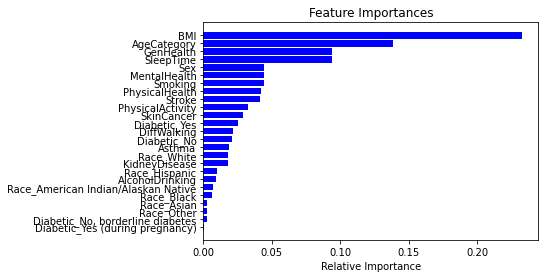

In [23]:
def calculate_feature_importances(data, target, scoring, n_splits, test_size, seed, prep_params=None):
    model = Model(RandomForestClassifier, data, target, scoring, n_splits, test_size, seed, prep_params)
    model.train()
    
    importances = model.model.feature_importances_
    indices = np.argsort(importances)
    graph_x = range(len(indices))
    
    plt.title('Feature Importances')
    plt.barh(graph_x, importances[indices], color='b', align='center')
    plt.yticks(graph_x, model.preprocessor.feature_columns[indices])
    plt.xlabel('Relative Importance')
    plt.show()

data_ = use_limited_data(full_data, 3200)
calculate_feature_importances(data=data_, target=TARGET_COLUMN, scoring=hp_scoring,
                              n_splits=hp_cv_splits, test_size=hp_test_size, seed=hp_seed)

### Explained Variance Ratio

For p=95% n_components should be 21



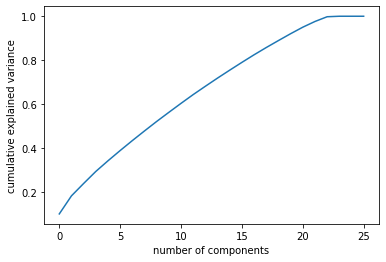

In [24]:
def calculate_explained_variance_ratio(data, p=0.95):
    X = Preprocessor.process(data).data
    
    pca = PCA(n_components=None, svd_solver='full', copy=True)
    reduced = pca.fit_transform(X)
    
    # extract the smallest number of components which
    # explain at least p% (e.g. 80%) of the variance
    n_components = 1 + np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p)
    print(f'For p={int(p*100)}% n_components should be {n_components}\n')

    # extract the values of the selected components
    #Z = pca.transform(X)[:, :n_components]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
data_ = use_limited_data(full_data, 3200)
calculate_explained_variance_ratio(data_, 0.95)

### Best Seed Calculation

In [25]:
def calculate_best_seed(seed_range, estimators, data, target, scoring, n_splits, test_size, prep_params=None):
    trainer = Trainer('trainer', data, target, scoring, n_splits, test_size,
                      seed=0, prep_params=prep_params)

    for estimator in estimators:
        name = estimator.__name__
        
        trainer.add_estimator(name, estimator)
        trainer.search_best_seed(name, seed_range)

calculate_best_seed(seed_range=range(0), estimators=[LogisticRegression],
                    data=full_data, target=TARGET_COLUMN, scoring=hp_scoring,
                    n_splits=(3, 1), test_size=hp_test_size)

Searching best seed for LogisticRegression
Best seed found as 0


# Model Definitions

## Logistic Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [26]:
# Add estimator
set_trainer.add_estimator('logistic', LogisticRegression, {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': [0.2, 0.5, 0.8],
    'solver': ['saga'],
    'max_iter': [10, 20, 40],
})

## Gaussian Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [comparing naive bayes classification algorithms](https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e)

In [27]:
# Add estimator
set_trainer.add_estimator('nb_gaussian', GaussianNB, {
    'var_smoothing': [0, 1e-10, 1e-9, 1e-8]
})

## kNN 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [28]:
# Add estimator
set_trainer.add_estimator('knn', KNeighborsClassifier, {
    'n_neighbors': [1, 2, 3, 4],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
})

## SVM 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [29]:
# Add estimator
set_trainer.add_estimator('svm', SVC, {
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'C': [10, 12, 15],
})

## Decision Tree 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [30]:
# Add estimator
set_trainer.add_estimator('dt', DecisionTreeClassifier, {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [1, 0.8, 0.5],
})

## MLP 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [31]:
# Add estimator
set_trainer.add_estimator('mlp', MLPClassifier, {
    'hidden_layer_sizes': [(100,), (128,128), (256,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001],
    'early_stopping': [True],
})

## Bagging
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [32]:
# Add estimator
set_trainer.add_estimator('bag', BaggingClassifier, {
    'n_estimators': [10, 20, 50],
    'max_samples': [1, 0.8, 0.5],
    'max_features': [1, 0.8, 0.5],
})

## Random Forest 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [33]:
# Add estimator
set_trainer.add_estimator('rf', RandomForestClassifier, {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': [1, 0.7],
    'max_samples': [1, 0.7],
})

## Gradient Boosting 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [34]:
# Add estimator
set_trainer.add_estimator('gb', GradientBoostingClassifier, {
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_depth': [3, 5],
})

## AdaBoost 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [35]:
# Add estimator
set_trainer.add_estimator('ada', LGBMClassifier, {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 2.0],
})

## LightGBM
[docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [36]:
# Add estimator
set_trainer.add_estimator('lgbm', LGBMClassifier, {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'objective': ['binary'],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
})

## Name 
[docs]()

# Training

### Default Trainer

In [37]:
prep_params = Preprocessor.params({
    'outlier_strategy': 'all',
    'encode_labels': True,
    'pca': False,
})

set_trainer.add_trainer(name='default', data=data, target=TARGET_COLUMN, scoring=hp_scoring,
        n_splits=hp_cv_splits, test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

# True = Single parameters, no grid search.
# False = Default grid parameters used, will do grid search.
if True:
    set_trainer.default.apply_estimator_params({
        'logistic': {'C': 0.2, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'},
    })
    
    # Gaussian Naive Bayes
    set_trainer.default.update_estimator_params('nb_gaussian', {'var_smoothing': 1e-08})
    
    # kNN
    set_trainer.default.update_estimator_params('knn', {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'})
    
    # SVM
    set_trainer.default.update_estimator_params('svm', {'C': 12, 'gamma': 'scale', 'kernel': 'poly'})
    
    # Decision Trees
    set_trainer.default.update_estimator_params('dt', {
        'criterion': 'gini', 'max_features': 0.8, 'min_samples_leaf': 3,
        'min_samples_split': 4, 'splitter': 'best'
    })
    
    # MLP
    set_trainer.default.update_estimator_params('mlp', {
        'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (256,),
        'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'solver': 'sgd'
    })
    
    # Bagging
    set_trainer.default.update_estimator_params('bag', {
        'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 20
    })
    
    # Random Forests
    set_trainer.default.update_estimator_params('rf', {
        'criterion': 'gini', 'max_features': 0.7, 'max_samples': 0.7,
        'min_samples_leaf': 1, 'min_samples_split': 4
    })
    
    # Gradient Boosting
    set_trainer.default.update_estimator_params('gb', {
        'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2
    })
    
    # AdaBoost
    set_trainer.default.update_estimator_params('ada', {'learning_rate': 1.0, 'n_estimators': 100})
    
    # LGBM
    set_trainer.default.update_estimator_params('lgbm', {
        'boosting_type': 'goss', 'colsample_bytree': 0.75, 'learning_rate': 0.2,
        'n_estimators': 100, 'objective': 'binary', 'subsample': 0.5
    })

### PCA Trainer

In [38]:
prep_params = Preprocessor.params({
    'outlier_strategy': 'all',
    'encode_labels': True,
    'pca': 0.95,
})

set_trainer.add_trainer(name='pca', data=data, target=TARGET_COLUMN, scoring=hp_scoring,
        n_splits=hp_cv_splits, test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

# True = Single parameters, no grid search.
# False = Default grid parameters used, will do grid search.
if True:
    set_trainer.default.apply_estimator_params({
        'logistic': {'C': 0.5, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'},
    })
        
    # Gaussian Naive Bayes
    set_trainer.pca.update_estimator_params('nb_gaussian', {'var_smoothing': 0})
    
    # kNN
    set_trainer.pca.update_estimator_params('knn', {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'})
    
    # SVM
    set_trainer.pca.update_estimator_params('svm', {'C': 12, 'gamma': 'scale', 'kernel': 'poly'})
    
    # Decision Trees
    set_trainer.pca.update_estimator_params('dt', {
        'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 2,
        'min_samples_split': 4, 'splitter': 'best'
    })
    
    # MLP
    set_trainer.pca.update_estimator_params('mlp', {
        'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (256,),
        'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'solver': 'sgd'
    })
    
    # Bagging
    set_trainer.pca.update_estimator_params('bag', {
        'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 50
    })
    
    # Random Forests
    set_trainer.pca.update_estimator_params('rf', {
        'criterion': 'gini', 'max_features': 0.7, 'max_samples': 0.7,
        'min_samples_leaf': 1, 'min_samples_split': 2
    })
    
    # Gradient Boosting
    set_trainer.pca.update_estimator_params('gb', {
        'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2
    })
    
    # AdaBoost
    set_trainer.pca.update_estimator_params('ada', {'learning_rate': 0.5, 'n_estimators': 200})
    
    # LGBM
    set_trainer.pca.update_estimator_params('lgbm', {
        'boosting_type': 'dart', 'colsample_bytree': 1, 'learning_rate': 0.1,
        'n_estimators': 200, 'objective': 'binary', 'subsample': 0.5
    })

### Training

In [39]:
# @Todos: t-test
# @Todos: Report

options = {
    # set trainer parameters
    'trainers': ['default'],
    
    # trainer parameters
    'estimators': ['logistic'],
    #'reset': False,
    #'seed': None,
    #'save': False,
}

for (trainer_name, trainer, model_name, model) in set_trainer.run_all_trainers(**options):
    # Get best params.
    print_dim(f"\nbest params: {model.best_result['params']}")
    
    # Show stats.
    print()
    trainer.get_scores_df(model_name).head()
    print()

    # Show predicts.
    trainer.get_results_df(model_name, ascending=True).head()

Trainer 1/1: default

Estimator: logistic

Model logistic is loaded from disk successfully.

best params: {'C': 0.5, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}



AttributeError: 'Model' object has no attribute 'best_stats'